## Implementing a GPT model from scratch to generate text
In this chapter **Sebastian** explains the code to implement the architecture of LLM that can be trained to generate human-like text.
The implementation includes normalized layer activations, shortcut connections, transformer blocks and, finally, the computation of the number of parameters and storage requirements of GPT models.  

In the previous chapter we imeplmented most of the component present in the architecture of LLM. Now, it's time to recreate the implementation of all the system and loading pretrained weights into our implementation. These weights are essentially the internal variables of the model that are essentiallu the internal variables of the model that are adjusted and optimized during the training process to minimize a specific loss function. 

**This optimization allows the model to learn from the training data** 



In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.7
torch version: 2.9.0
tiktoken version: 0.12.0


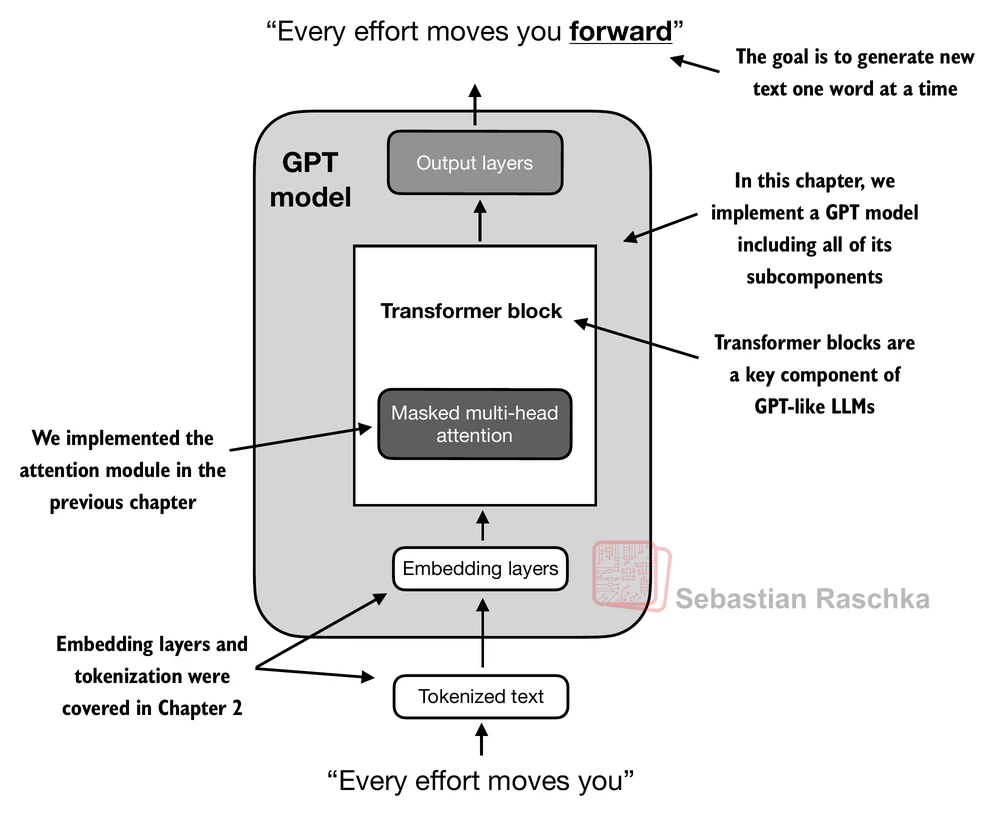

In [2]:
# Firstly, we need to specify the configuration of the small GPT-2 model via dictionary
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size -----> as used by the BPE
    "context_length": 1024, # Context length ----> max number of input tokens the model can handle
    "emb_dim": 768,         # Embedding dimension ----> each token will be transformed into vector 768-dimension
    "n_heads": 12,          # Number of attention heads ----> how many parallel attention mechanisms
    "n_layers": 12,         # Number of layers ----> how many transformer blocks
    "drop_rate": 0.1,       # Dropout rate ----> regularization technique to prevent overfitting
    "qkv_bias": False       # Query-Key-Value bias ----> determines wheter to include a bias vector in the Linear layers of the multi-head attention for query, key and value computations.
    
}

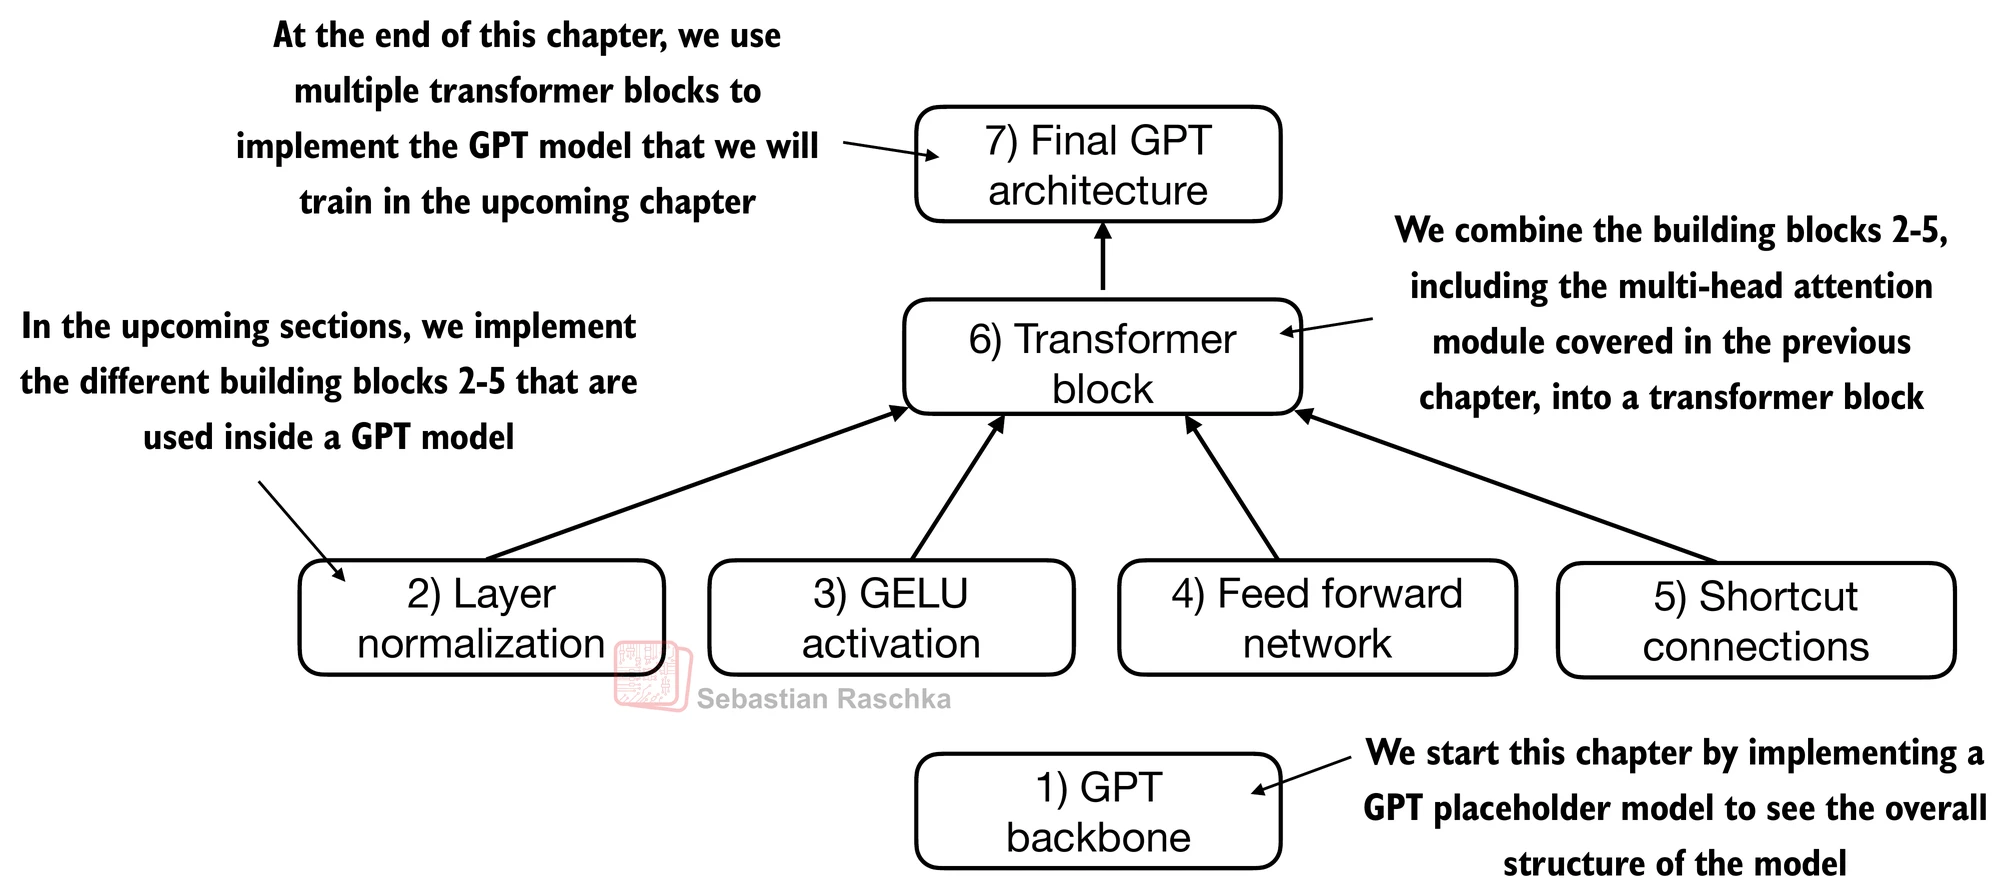

In [3]:
import torch
import torch.nn as nn
# Use this as a placeholder for the full GPT model implementation.

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Token embedding layer from vocabulary to embedding dimension
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # Positional embedding layer to encode token positions
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # Dropout layer for regularization
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # Output head to project embeddings back to vocabulary size
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # Extract batch size and sequence length from input indices
        batch_size, seq_len = in_idx.shape
        # Get token embeddings 
        tok_embeds = self.tok_emb(in_idx)
        # Get positional embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # Combine token and positional embeddings
        x = tok_embeds + pos_embeds
        # Apply dropout
        x = self.drop_emb(x)
        # Pass through transformer blocks
        x = self.trf_blocks(x)
        # Apply final layer normalization
        x = self.final_norm(x)
        # Project to vocabulary size to get logits, through the logit computation with the linear output layer.
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

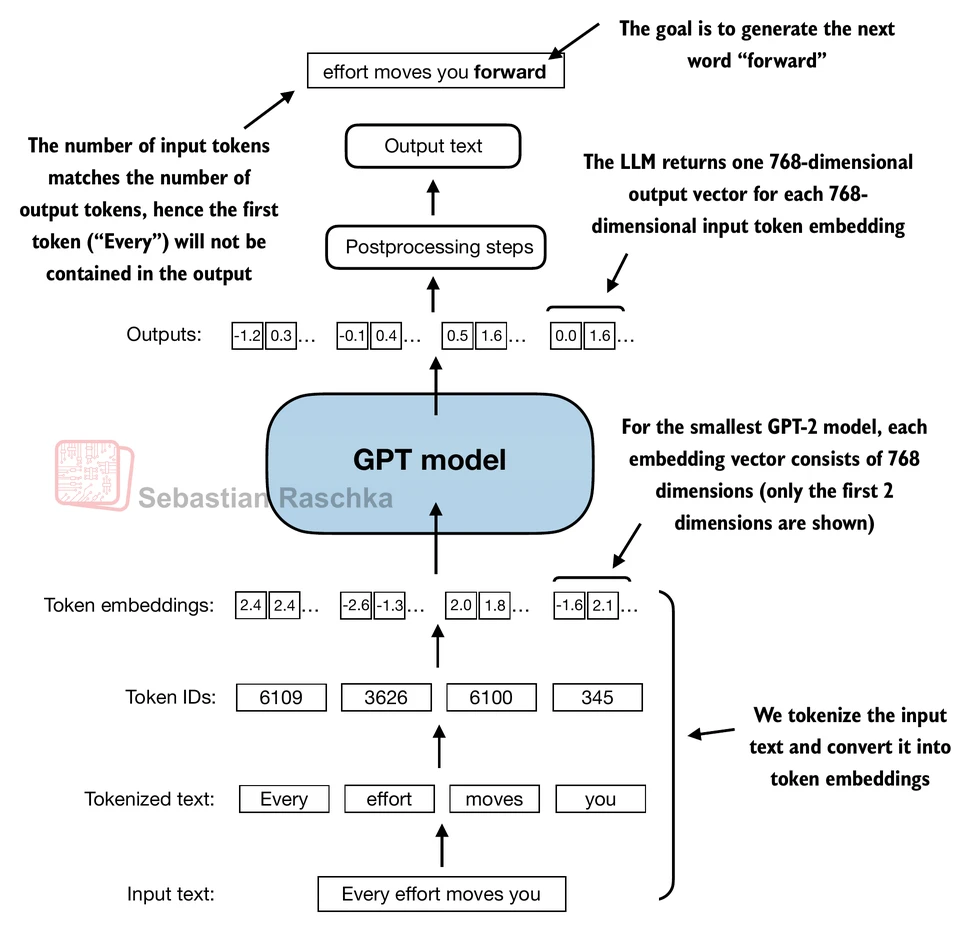

In [ ]:
import tiktoken

# Initialize the tokenizer for GPT-2
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
# Stack the list of tensors into a single tensor along a new dimension (batch dimension)
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

''' 
The output tensor has two rows corresponding to the two text samples.
Each text sample consists of four tokens; each token is a 50 257-dimension vector, which
matches the size of the tokenizer's vocabulary. 
'''

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


#### Normalizing activations with layer normalization

During the training dynamics we can face with the problem know as [*vanishing or exploding gradients*](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
In other words, the network has difficulty learning the underlying patterns in the data to a degree that would allow it to make accurate predictions or decisions.
**The layer normalization** is able to improve the stability and efficiency of neural network training.
*main concept: adjust the activations (outputs) of neural network layer to have a mean of 0 and a variance of 1 (unit variance)*.

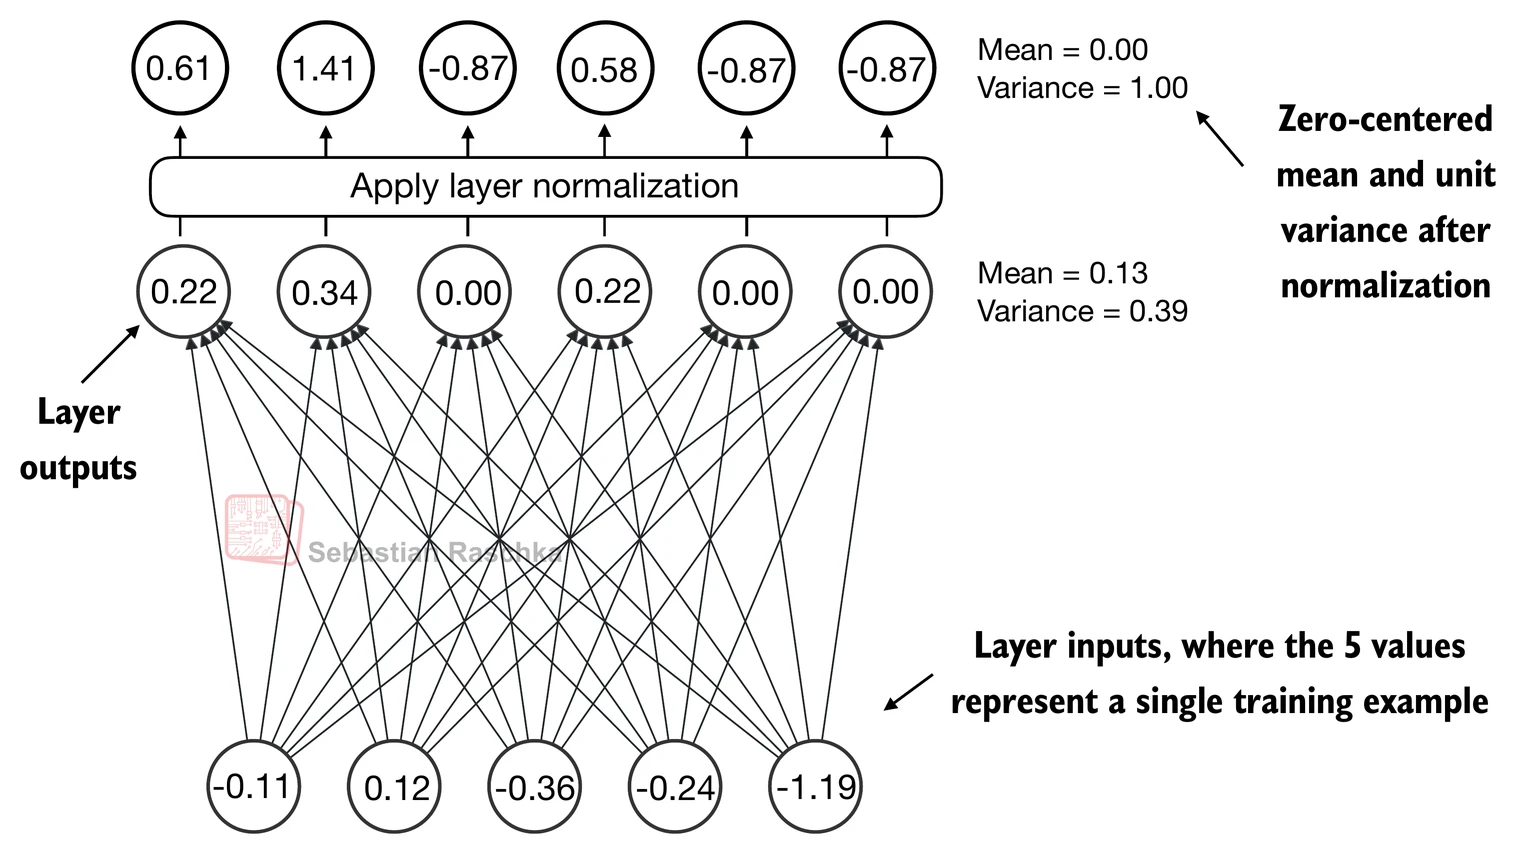

In [15]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 
print(f"The examples are the following: \n 1. -> {batch_example[0]}, \n 2. -> {batch_example[1]}")

# Now let's reproduce linear layer, then applying an activation function the results become positive.
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

The examples are the following: 
 1. -> tensor([-0.1115,  0.1204, -0.3696, -0.2404, -1.1969]), 
 2. -> tensor([ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [16]:
# *keepdim parameter* is used to ensuere that the output tensor retains the same number of dimensions as the input tensor.
# *dim parameter* specifies the dimension along which the calculation off the statistic should be performed in a tensor.
#  dim = -1   --->   it refers to the last dimension. 
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


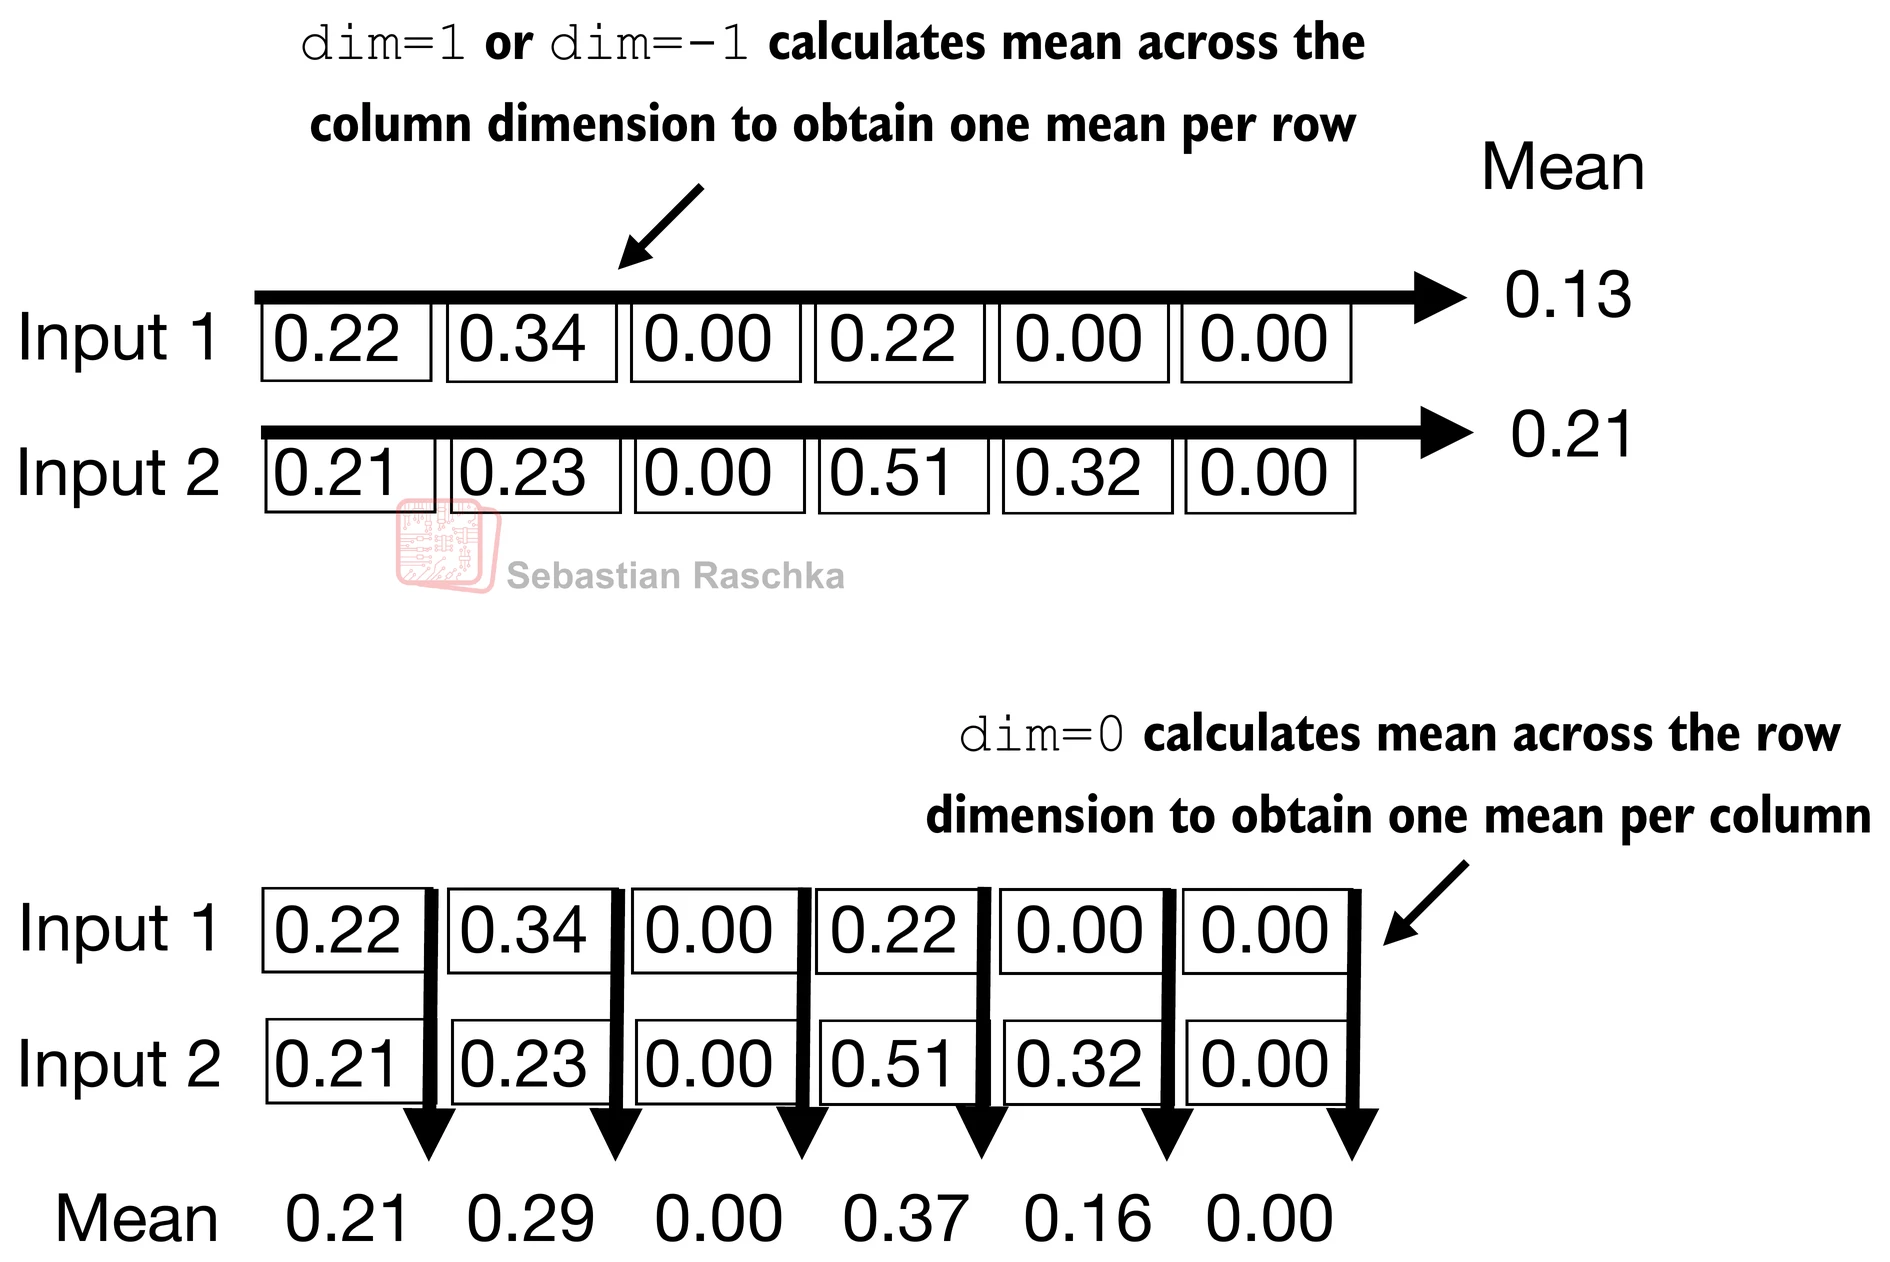

In [17]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [18]:
# To improve readability, we can also turn off the scientific notation.

torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
# Now encapsulate this process in a PyTorch module

# This layer normalization operates on the last dimension, which represents the embedding dimension (emb_dim)
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # To prevent division by zero during normalzation
        self.eps = 1e-5

        # These parameters are trainable parameters that LLM adjusts during training phase.
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        '''
        In this implementation we set *unbiased = False* to use this formula: sum_i(x_i - x*)^2 / n to compute variance where n is the sample size.
        This formula doesn't include Bassel's correction (which use n-1), but if n large ---> n = n-1
        Link: https://en.wikipedia.org/wiki/Bessel%27s_correction
        '''
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift